In [9]:
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, History
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import numpy as np
from PIL import Image
import math
import os 
# from numba import cuda
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn import metrics
from sklearn.cluster import KMeans
from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import pandas as pd

import cv2
import newscripts as myutils

In [7]:
gpu_options = tf.GPUOptions(allow_growth=True)
custom_config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True, gpu_options=gpu_options)
custom_config.gpu_options.allocator_type = 'BFC'
custom_config.gpu_options.per_process_gpu_memory_fraction = 0.90
session = tf.InteractiveSession(config=custom_config)

device_lib.list_local_devices()

c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10196260007878915630, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7730941132
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1623025845773963065
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [11]:
## Images loading 
datadir = "C:/Users/mostafaosama2/Desktop/autoenctrain/60k"

trainData = datadir + "/train"
testData = datadir + "/test"

n_training_samples = len(trainData) 
n_testing_samples = len(testData)

new_train = []
new_test = []
train_image_names = []
test_image_names = []

for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = cv2.imread(os.path.join(trainData, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        new_train.append(np.asarray( resized_image, dtype="uint8" ))
        train_image_names.append(filename)

for filename in os.listdir(testData):
    if filename.endswith('.tif'):
        image = cv2.imread(os.path.join(testData, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96))
        new_test.append(np.asarray( resized_image, dtype="uint8" ))
        test_image_names.append(filename)

## Data preprocessing

x_train = np.asarray(new_train)
x_test = np.asarray(new_test)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

KeyboardInterrupt: 

In [ ]:
n_epochs = 200
batch_size = 32
adam = Adam(lr=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizer = adam
loss1 = 'mean_squared_error'
loss2 = 'mean_squared_error'

input_img = Input(shape=(96, 96, 3))  # adapt this if using `channels_first` image data format

encoder = Conv2D(filters=16, kernel_size=(3,3),strides=1, padding='same')(input_img)#x^2*16
encoder = LeakyReLU()(encoder)
encoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(encoder)#x^2*32
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(filters=64, kernel_size=(3,3),strides=2, padding='same')(encoder)#(x/2)^2*64
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = MaxPooling2D()(encoder)#(x/4)^2*64
encoder = Conv2D(filters=128, kernel_size=(3,3),strides=2, padding='same')(encoder)#(x/8)^2*128
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = MaxPooling2D()(encoder)#(x/16)^2*64
encoder = Conv2D(filters=64, kernel_size=(3,3),strides=1, padding='same')(encoder)#(x/16)^2*64
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(encoder)#(x/16)^2*32
encoder = LeakyReLU()(encoder)


bottleneck = Conv2D(filters=32, kernel_size=(1,1),strides=1, padding='same')(encoder)#(x/16)^2*16
bottleneck = LeakyReLU()(bottleneck)


decoder = Conv2D(filters=32, kernel_size=(1,1),strides=1, padding='same')(bottleneck)#(x/16)^2*32
decoder = LeakyReLU()(decoder)
decoder = Conv2D(filters=64, kernel_size=(3,3),strides=1, padding='same')(decoder)#(x/16)^2*64
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D()(decoder)#(x/8)^2*64
decoder = Conv2DTranspose(filters=128, kernel_size=(3,3),strides=2, padding='same')(decoder)#(x/4)^2*128
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D()(decoder)#(x/2)^2*128
decoder = Conv2DTranspose(filters=64, kernel_size=(3,3),strides=2, padding='same')(decoder)#x^2*64
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*32
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2D(filters=16, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*16
decoder = LeakyReLU()(decoder)
decoder = Conv2D(filters=3, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*3
decoded = LeakyReLU()(decoder)

regressor = Flatten()(bottleneck)
regressor = Dense(128)(regressor) 
regressor = LeakyReLU()(regressor)
regressor = BatchNormalization()(regressor)
regressor = Dense(64)(regressor) 
regressor = LeakyReLU()(regressor)
regressor = BatchNormalization()(regressor)
regressor = Dense(32)(regressor) 
regressor = LeakyReLU()(regressor)
regressor = BatchNormalization()(regressor)
regressor = Dense(1, activation='sigmoid')(regressor) # add batch norm
# exploding gradients
#weight decay or momentum

autoencoder = Model(input_img, [decoded, regressor])
autoencoder.compile(optimizer=optimizer , loss=[loss1,loss2])

mainDr = "C:/Users/mostafaosama2/Desktop/Generalised-WSI-Clustering/notebooks/"
filepath = mainDr + "{}_epochs{}_batch{}.h5".format(loss2, n_epochs,batch_size)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, mode='min', verbose=0, restore_best_weights=True)
csv_logger = CSVLogger('training.log')
callbacks_list = [checkpoint, ES, csv_logger]

autoencoder.summary()

In [ ]:
# csvFilePath = "C:/Users/mostafaosama2/Desktop/Kaggle-Data/train_labels.csv"
# df = pd.read_csv(csvFilePath)
# trainlabels = []
# testlabels = []

# for image in train_image_names:
#     label_index = df[df["id"] == image.split(".")[0]].index[0]
#     trainlabels.append(df["label"][label_index])
    
# for image in test_image_names:
#     label_index = df[df["id"] == image.split(".")[0]].index[0]
#     testlabels.append(df["label"][label_index])

labels_directory = "C:/Users/mostafaosama2/Desktop/autoenctrain/kather_labels"
trainlabels = myutils.loadLabelsFromsubdirectoryindex(train_image_names, labels_directory)
testlabels = myutils.loadLabelsFromsubdirectoryindex(test_image_names, labels_directory)

In [9]:
trainlabels = np.asarray(trainlabels)
testlabels = np.asarray(testlabels)
print(x_train.shape)
print(x_test.shape)
print(trainlabels.shape)
print(testlabels.shape)

(45000, 96, 96, 3)
(15000, 96, 96, 3)
(45000,)
(15000,)


In [60]:
with tf.device('/GPU:0'):
    autoencoder_train = autoencoder.fit(
                    x_train, 
                    [x_train, trainlabels],
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, [x_test, testlabels]),
                    callbacks=callbacks_list
                   )

Train on 45000 samples, validate on 15000 samples
Epoch 1/300
45000/45000 [==============================] - 242s 5ms/step - loss: 0.1707 - leaky_re_lu_167_loss: 0.0441 - dense_40_loss: 0.1266 - val_loss: 0.1752 - val_leaky_re_lu_167_loss: 0.0341 - val_dense_40_loss: 0.1411

Epoch 00001: val_loss improved from inf to 0.17521, saving model to C:/Users/mostafaosama2/Desktop/Generalised-WSI-Clustering/notebooks/mean_squared_error_epochs300_batch64.h5
Epoch 2/300
45000/45000 [==============================] - 205s 5ms/step - loss: 0.1393 - leaky_re_lu_167_loss: 0.0332 - dense_40_loss: 0.1062 - val_loss: 0.3545 - val_leaky_re_lu_167_loss: 0.0372 - val_dense_40_loss: 0.3173

Epoch 00002: val_loss did not improve from 0.17521
Epoch 3/300
45000/45000 [==============================] - 191s 4ms/step - loss: 0.1296 - leaky_re_lu_167_loss: 0.0323 - dense_40_loss: 0.0973 - val_loss: 0.2471 - val_leaky_re_lu_167_loss: 0.0347 - val_dense_40_loss: 0.2125

Epoch 00003: val_loss did not improve from 0.

KeyboardInterrupt: 

In [61]:
autoencoder = load_model(filepath)

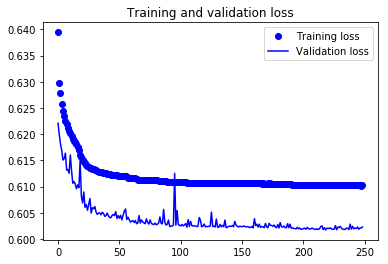

In [48]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(249)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

autoencoder.save('epochs{}_batch{}_{}.h5'.format(n_epochs, batch_size, val_loss[-1]))

In [62]:
labels_pred = autoencoder.predict(x_test)[1]
for i in range(len(labels_pred)):
    if labels_pred[i] < 0.5:
        labels_pred[i] = 0
    else:
        labels_pred[i] = 1
        
evaluation = metrics.classification_report(testlabels, labels_pred)
print(evaluation)


              precision    recall  f1-score   support

           0       0.91      0.92      0.91      8846
           1       0.88      0.87      0.88      6154

    accuracy                           0.90     15000
   macro avg       0.90      0.89      0.90     15000
weighted avg       0.90      0.90      0.90     15000



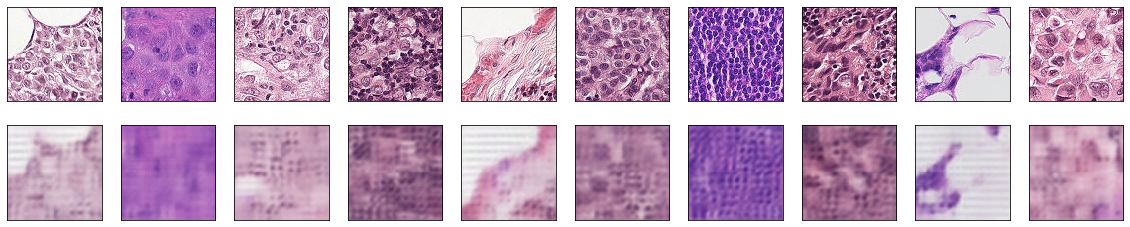

In [63]:
decoded_imgs = autoencoder.predict(x_test)[0]
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


(15000, 6, 6, 32)
(15000, 1152)


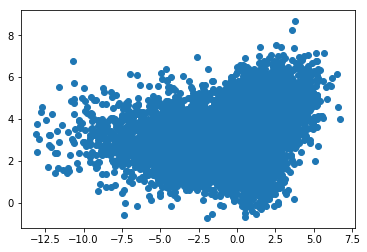

In [65]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

layer_name = 'conv2d_116'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer(layer_name).output)

encoded_imgs = intermediate_layer_model.predict(x_test)
print(encoded_imgs.shape)
encoded_imgs = encoded_imgs.reshape((len(x_test),-1))
print(encoded_imgs.shape)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1])

(15000, 50)


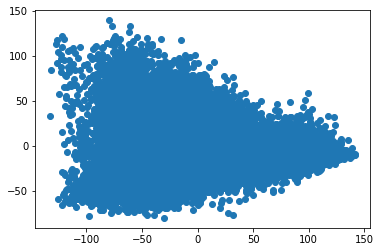

In [66]:
pca = PCA(n_components=50)
pcatransformedData = pca.fit_transform(encoded_imgs)
print(pcatransformedData.shape)
plt.scatter(pcatransformedData[:, 0], pcatransformedData[:, 1])

(15000, 2)


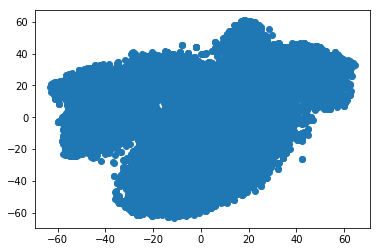

In [67]:
tsne = TSNE(n_components=2)
transformedData = tsne.fit_transform(pcatransformedData)

print(transformedData.shape)
plt.scatter(transformedData[:, 0], transformedData[:, 1])

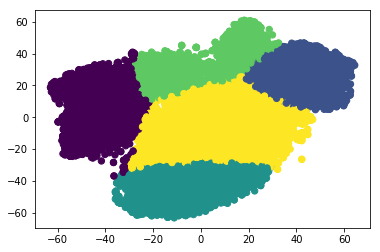

In [69]:
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models
gmm = GaussianMixture(n_components=5).fit(transformedData)
gmmlabels_ = gmm.predict(transformedData)
plt.scatter(transformedData[:, 0], transformedData[:, 1], c=gmmlabels_, s=40, cmap='viridis');